### CITS4404 Practical Project

# Camo Worms!

Australian _velvet worms_ come in many colours, possibly as a camouflage function ([Current Biology](https://www.cell.com/current-biology/comments/S0960-9822(11)00208-9)).

In [1]:
import matplotlib as mpl

from src.algorithm import *
from src.image_loading import *
from src.image_manipulation import *
from src.plotting import *
from src.worm import *
from src.worm_mask import *
from src.algorithms.greedy_ga import *
from src.algorithms.local_search import *

from typing import Callable

# Controls the size of the plots.
mpl.rcParams['figure.dpi']= 140


# 1. Source Image

## 1.1. Load the source image

Loads the grayscale image and crops it into a NumPy array.

shape (max, min, mean, std. deviation)
(240, 720) (210.0, 0.0, 49.7, 34.4)


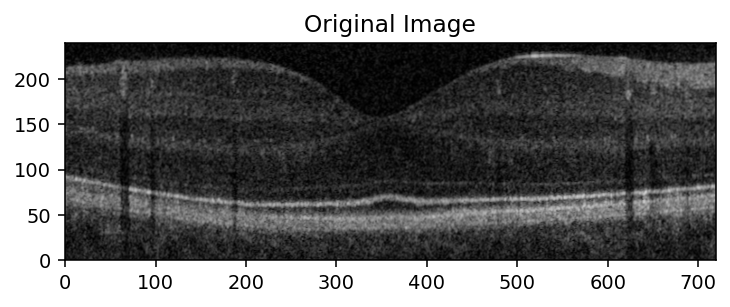

In [2]:
def draw_image(image):
    """ Draws the grayscale image with black as 0 and white as 255. """
    # use vmin and vmax to stop imshow from scaling
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower')


image = crop(load_image("images", "original"), (320, 560, 160, 880))
print("shape (max, min, mean, std. deviation)")
print("{} ({}, {}, {}, {})".format(
    np.shape(image), np.max(image), np.min(image),
    round(float(np.mean(image)), 1), round(float(np.std(image)), 1)
))
draw_image(image)
plt.title("Original Image")
plt.show()


## 1.2. Traditional Image Processing

Traditional image processing techniques such as blur, constant convolutions, median windows, and FFT denoising can be used to reduce the noise in an image.

Blurred Image: shape=(240, 720), min=2.16, mean=49.68, max=161.90


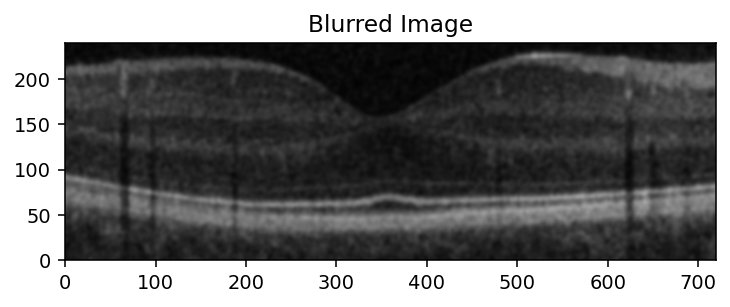

Mean Windowed Image: shape=(240, 720), min=0.00, mean=49.57, max=192.78


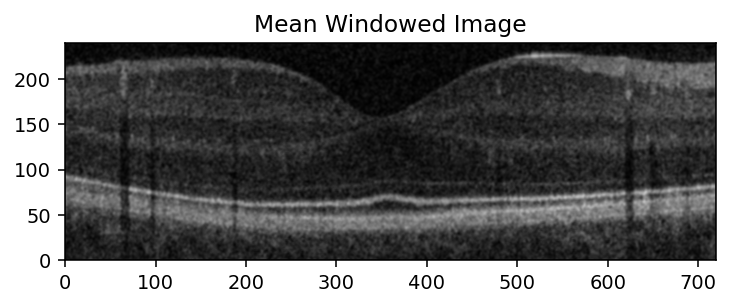

Median Windowed Image: shape=(240, 720), min=0.00, mean=49.66, max=197.00


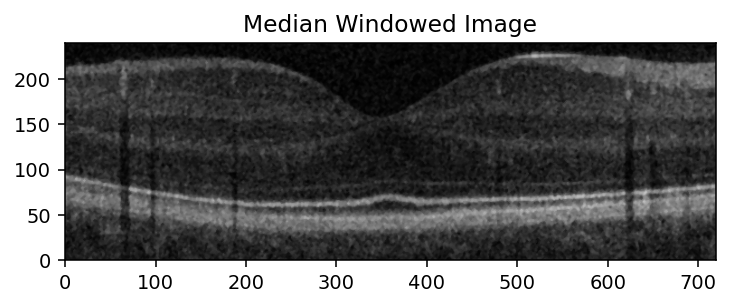

FFT Denoise Image: shape=(240, 720), min=0.00, mean=49.68, max=194.30


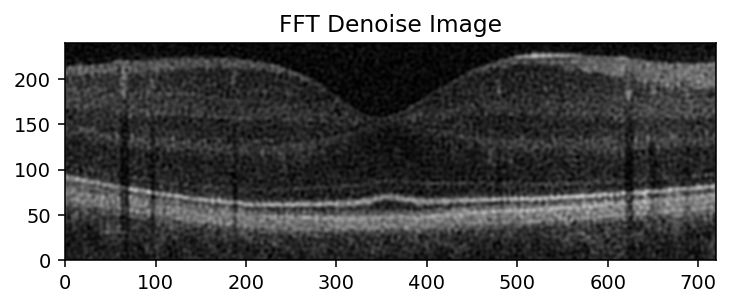

Original Image: shape=(240, 720), min=0.00, mean=49.68, max=210.00


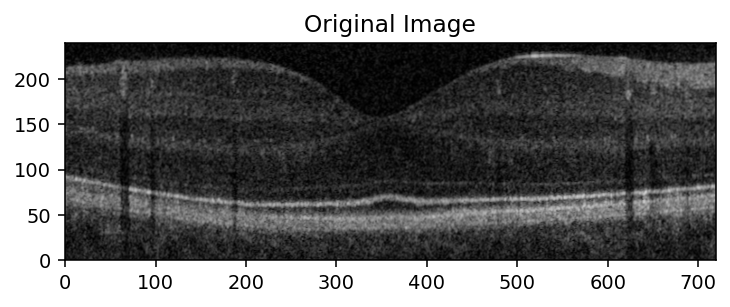

In [3]:
def test_traditional_approach(image, method: Callable, title: str):
    """ Plots the application of a traditional image processing method. """
    processed = method(image)
    print("{}: shape={}, min={:.2f}, mean={:.2f}, max={:.2f}".format(
        title, processed.shape, np.amin(processed), np.mean(processed), np.amax(processed)
    ))
    draw_image(processed)
    plt.title(title)
    plt.show()


test_traditional_approach(image, blur, "Blurred Image")
test_traditional_approach(image, mean_window, "Mean Windowed Image")
test_traditional_approach(image, median_window, "Median Windowed Image")
test_traditional_approach(image, fft_denoise, "FFT Denoise Image")
test_traditional_approach(image, lambda x: x, "Original Image")

## 1.3. Brightening the Image

The above traditional approaches show that there are many ways to reduce noise in an image, but each has their own limitations and benefits. From the above, the median filter looks the best for our purposes of maintaining clear lines in the image for our worms to follow.

However, the image still contains some trends that are very faint compared to others in the image. This can be helped by brightening and darkening the images based upon the brightness if their surroundings.

Scaled Image: shape=(240, 720), min=0.00, mean=60.32, max=255.00


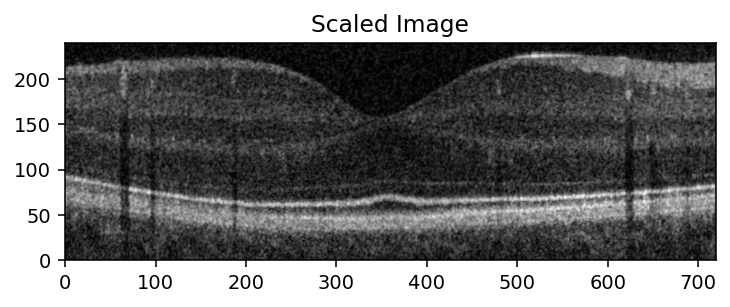

Extremify Image: shape=(240, 720), min=0.00, mean=51.69, max=255.00


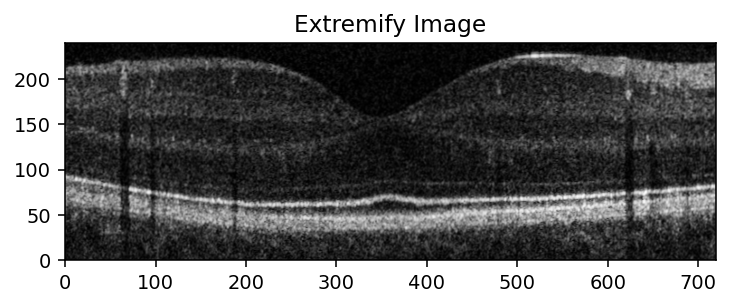

Locally Brightened Image: shape=(240, 720), min=-2.17, mean=53.61, max=252.22


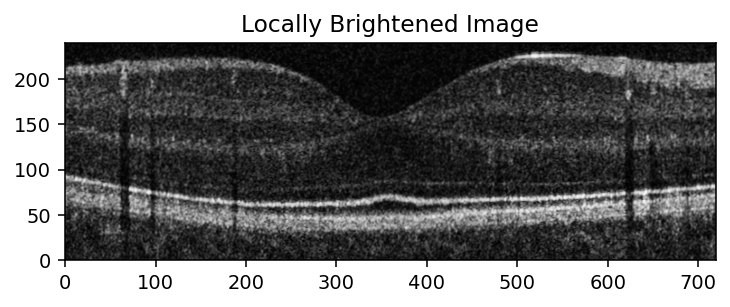

Edge Enhanced Image: shape=(240, 720), min=0.00, mean=52.11, max=249.83


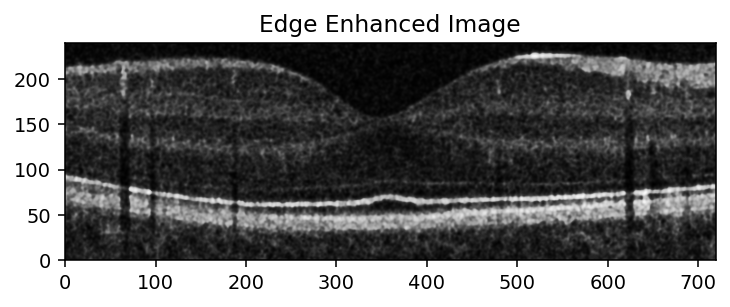

Original Image: shape=(240, 720), min=0.00, mean=49.68, max=210.00


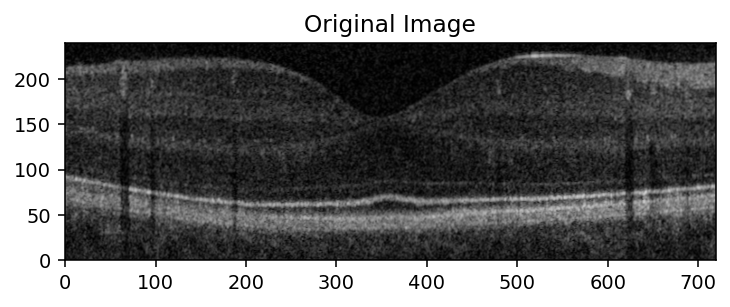

In [4]:
test_traditional_approach(image, scale_brighten, "Scaled Image")
test_traditional_approach(image, extremify, "Extremify Image")
test_traditional_approach(image, local_brighten, "Locally Brightened Image")
test_traditional_approach(image, edge_enhance, "Edge Enhanced Image")
test_traditional_approach(image, lambda x: x, "Original Image")

With these basic image transformation methods, we can enhance the lines in the image, but not very well. Hopefully our worms can do a better job.

# 2. Worm Representation

The camouflage worms are represented by bezier curves, and are specified in src/worm.py.

## 2.1. Generating Random Worms

In [5]:
def generate_random_clew(size: int, imshape: Tuple[int, int]):
    """ Generates a random clew of size worms. """
    clew = []
    for i in range(size):
        clew.append(CamoWorm.random(imshape))
    return clew

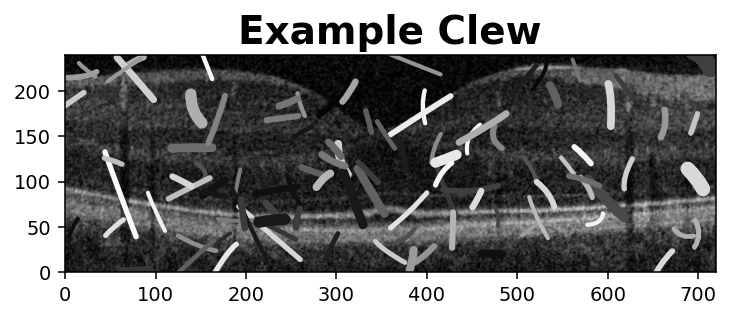

In [6]:
# Initialise clew of 100 and draw

clew = generate_random_clew(100, image.shape)
drawing = Drawing(image)
drawing.add_worms(clew)
drawing.plot(title="Example Clew")

## 2.2. Example Camo Worms

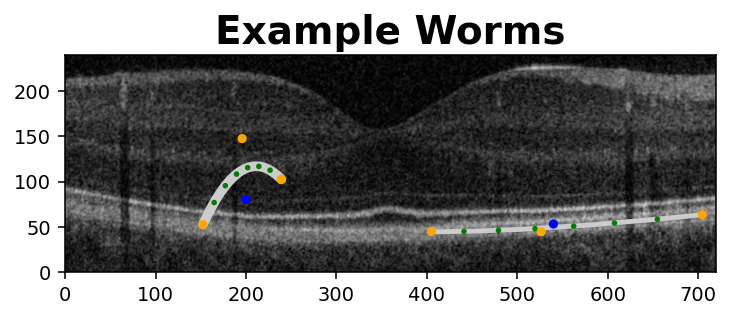

In [7]:
# Draw a single worm along with control points and some sample points

example_worm = CamoWorm(200, 80, 50, np.pi/6, 70, np.pi/3, 10, 0.8)
example_worm_2 = CamoWorm(540, 53, 150, np.pi/50, -30, np.pi/12, 5, 0.8)


def draw_example_bezier_png():
    drawing = Drawing(image)
    for worm in [example_worm, example_worm_2]:
        drawing.add_worms(worm)
        drawing.add_dots(worm.intermediate_points(8), radius=2, color='green')
        drawing.add_dots(worm.control_points(), color='orange')
        drawing.add_dots((worm.x, worm.y), color='blue')

    drawing.plot(title="Example Worms")


draw_example_bezier_png()

## 3. Determine what is beneath a worm

Firstly, we will need to determine what pixels are beneath the worm. This is done by creating a mask based on the distance to the worm. To simplify this calculation, we estimate the distance to the worm as the minimum distance to one of N points along the worm. This mask can then be used to filter out only the pixels of the image that fall under the worm.


## 3.1. Reduce the number of points in a curve

The calculation of points on a bezier curve does not give points that are uniformly far apart. Therefore, some sections of the curve would be much more dense than other areas. This wastes computation time. Therefore, the function below filters out the set of points along a curve to only include points that are a certain distance apart.


## 3.2. Generation of circles

We create the mask by drawing a series of circles into a NumPy array. These circle masks can be relatively expensive to compute compared to the generation of the mask. Therefore, we can cache them to save on computation time.

## 3.3. Generate a worm mask from a bezier curve

To save on computation time, the masks that we generate only encompass the bounding box of the worm. Offsets are then used to relate the mask to the subset of the image that they represent.

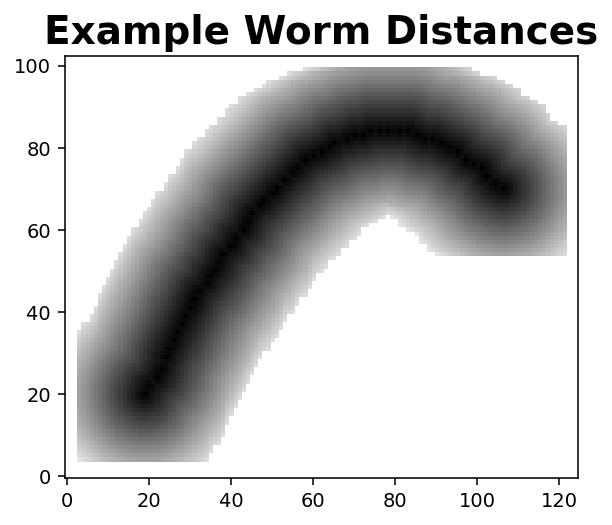

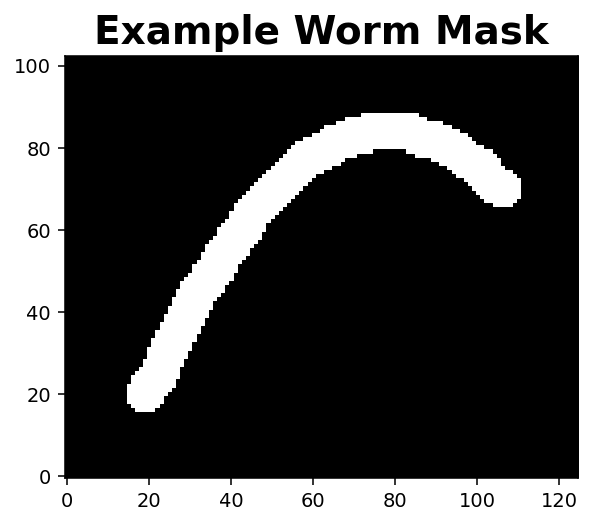

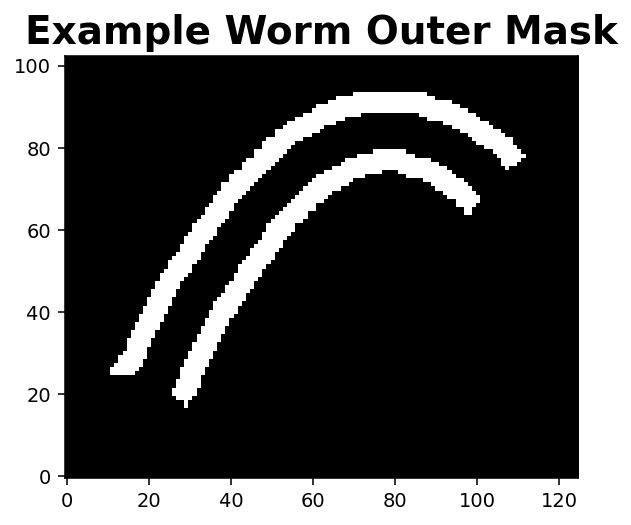

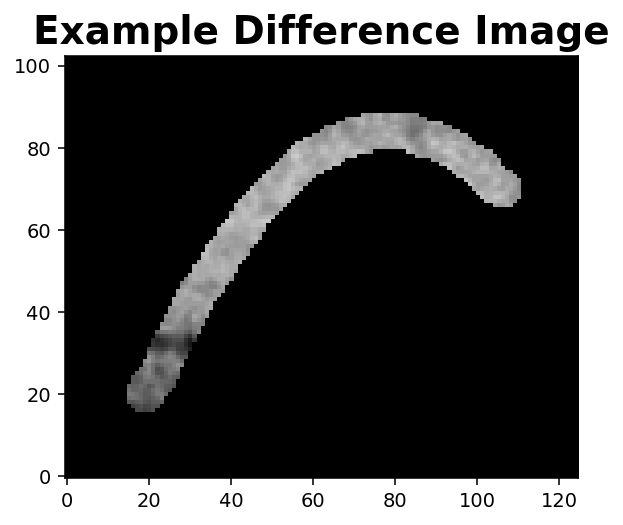

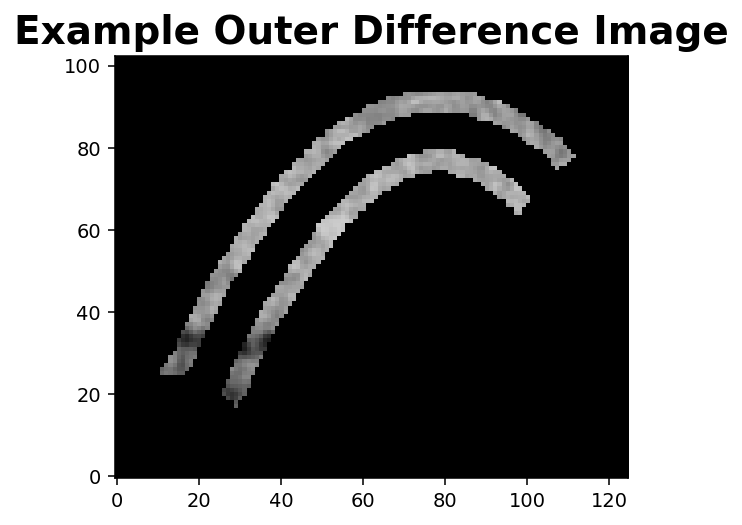

Area = 1225.0, Intersection = 0.6


In [8]:
# Compare the generated mask with the worm used in the example above.
worm_mask = WormMask(example_worm, image)
outer_mask = worm_mask.create_outer_mask()
Drawing(10 * np.sqrt(worm_mask.distances)).plot(title="Example Worm Distances")
Drawing(worm_mask.mask * 255).plot(title="Example Worm Mask")
Drawing(outer_mask.mask * 255).plot(title="Example Worm Outer Mask")
Drawing(worm_mask.difference_image() * 255).plot(title="Example Difference Image")
Drawing(outer_mask.difference_image() * 255).plot(title="Example Outer Difference Image")

example_intersecting_worm = example_worm.copy(x=example_worm.x + 5)
intersecting_worm_mask = WormMask(example_intersecting_worm, image)
print("Area = {:.1f}, Intersection = {:.1f}".format(worm_mask.area, worm_mask.intersection(intersecting_worm_mask)))


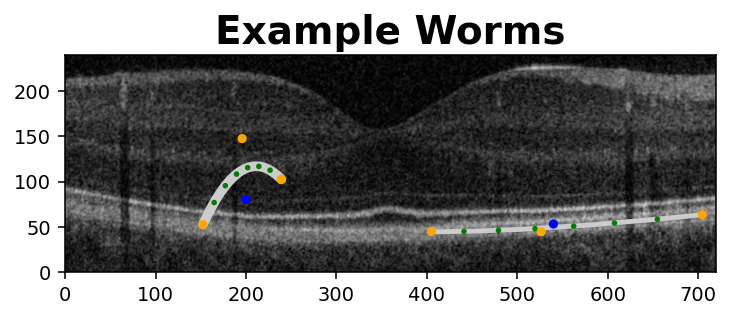

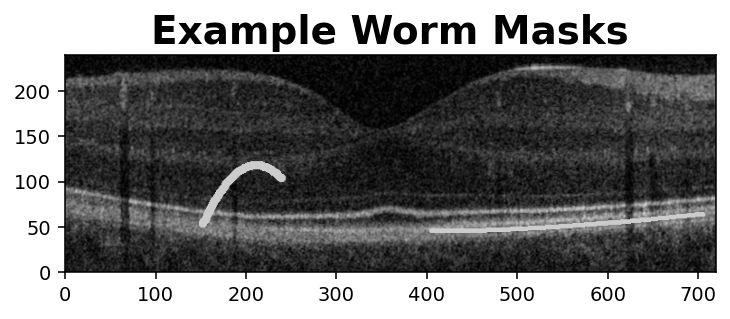

In [9]:
draw_example_bezier_png()

# Draw the masks to visualise their similarities to the real curves.
def draw_example_worm_masks(title="Example Worm Masks"):
    image_with_worm_masks = image.copy()
    for worm in [example_worm, example_worm_2]:
        mask = WormMask(worm, image)
        mask.draw_into(image_with_worm_masks, worm.colour * 255.0)
    Drawing(image_with_worm_masks).plot(title=title)


draw_example_worm_masks()


# 4. Search Optimisation
Determining the colour and width of the worms by evolution is particularly difficult. However, we can just use the mean colour under the mask for the colour of the worm. Additionally, we can use search over many width values to determine the best width for the worm.

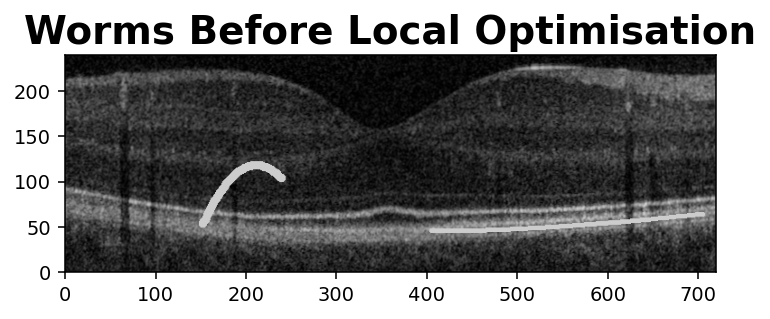

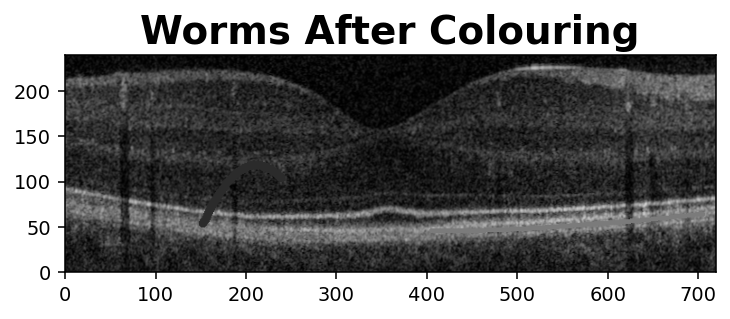

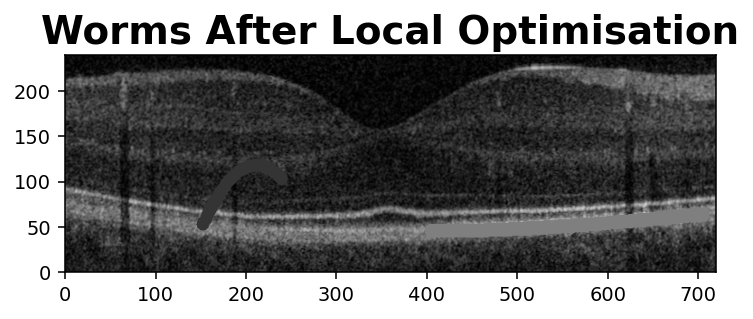

In [10]:
draw_example_worm_masks(title="Worms Before Local Optimisation")

# Set the worms to the most common colour under them.
example_mask = WormMask(example_worm, image)
example_mask_2 = WormMask(example_worm_2, image)
example_worm.colour = example_mask.median_colour()
example_worm_2.colour = example_mask_2.median_colour()
draw_example_worm_masks(title="Worms After Colouring")

# Search for the best width for the example worms.
locally_optimise_worm(image, example_worm)
locally_optimise_worm(image, example_worm_2)
draw_example_worm_masks(title="Worms After Local Optimisation")


# 5. Optimisation Algorithm

## 5.1 Greedy Search
This algorithm randomly mutates a population of camo worms, and only keeps the mutations that improve the score of the worms.

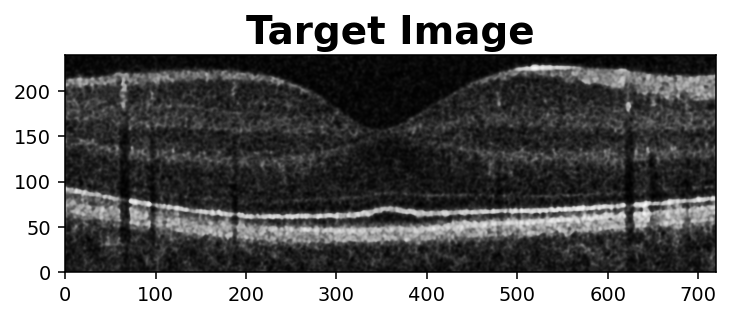

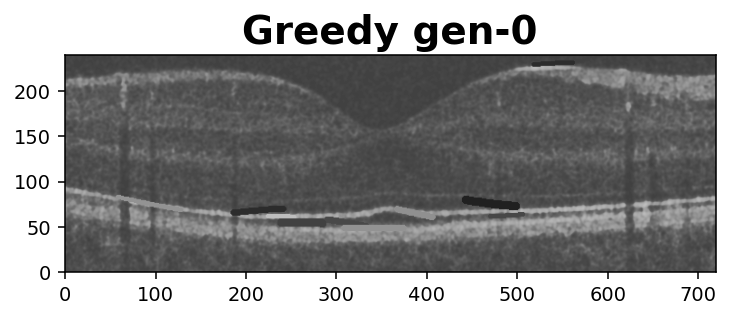

In [11]:
ga = GreedyClewEvolution(image, 10)
ga.plot_clew(show_target_image=True)


Now, we can run the genetic algorithm using our basic functions as a baseline test.

Generation 1: SSIM = 0.297, Scores = 56 ± 20, [39, 95], Worms = 10  (took 0.19 sec)


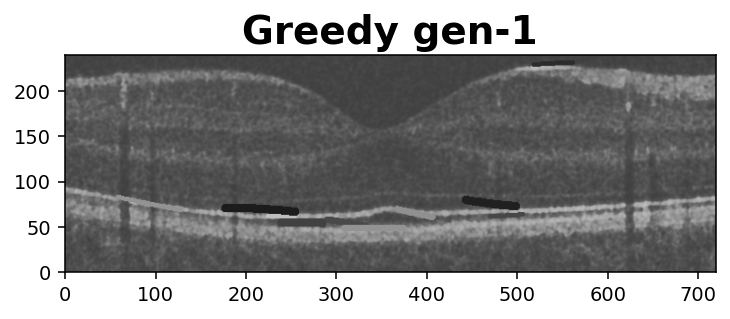

In [12]:
ga.run_generation()
ga.plot_clew()

Generation 2: SSIM = 0.298, Scores = 55 ± 20, [39, 95], Worms = 11  (took 0.77 sec)
Generation 3: SSIM = 0.296, Scores = 58 ± 20, [38, 95], Worms = 11  (took 0.17 sec)
Generation 4: SSIM = 0.298, Scores = 61 ± 18, [40, 95], Worms = 11  (took 0.17 sec)
Generation 5: SSIM = 0.299, Scores = 66 ± 17, [40, 95], Worms = 11  (took 0.17 sec)
Generation 6: SSIM = 0.302, Scores = 65 ± 16, [40, 95], Worms = 12  (took 0.77 sec)
Generation 7: SSIM = 0.298, Scores = 65 ± 16, [43, 95], Worms = 12  (took 0.18 sec)
Generation 8: SSIM = 0.297, Scores = 64 ± 15, [43, 95], Worms = 13  (took 0.79 sec)
Generation 9: SSIM = 0.297, Scores = 65 ± 14, [44, 95], Worms = 13  (took 0.19 sec)
Generation 10: SSIM = 0.300, Scores = 66 ± 14, [44, 95], Worms = 13  (took 0.20 sec)


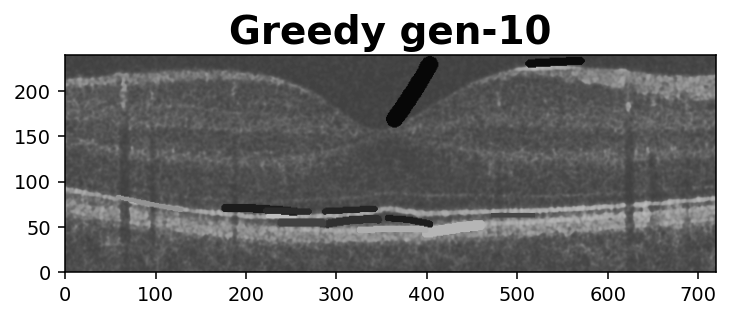

In [13]:
ga.run_generations(9)
ga.plot_clew()

Generation 11: SSIM = 0.301, Scores = 69 ± 15, [44, 95], Worms = 13  (took 0.20 sec)
Generation 12: SSIM = 0.301, Scores = 70 ± 16, [44, 97], Worms = 13  (took 0.20 sec)
Generation 13: SSIM = 0.299, Scores = 71 ± 20, [28, 97], Worms = 13  (took 0.20 sec)
Generation 14: SSIM = 0.301, Scores = 71 ± 19, [28, 97], Worms = 14  (took 0.85 sec)
Generation 15: SSIM = 0.301, Scores = 71 ± 20, [29, 105], Worms = 14  (took 0.20 sec)
Generation 16: SSIM = 0.301, Scores = 72 ± 21, [29, 106], Worms = 14  (took 0.20 sec)
Generation 17: SSIM = 0.302, Scores = 70 ± 22, [29, 106], Worms = 15  (took 0.80 sec)
Generation 18: SSIM = 0.302, Scores = 71 ± 20, [39, 105], Worms = 15  (took 0.21 sec)
Generation 19: SSIM = 0.302, Scores = 69 ± 21, [36, 105], Worms = 16  (took 0.81 sec)
Generation 20: SSIM = 0.302, Scores = 70 ± 24, [36, 128], Worms = 16  (took 0.22 sec)


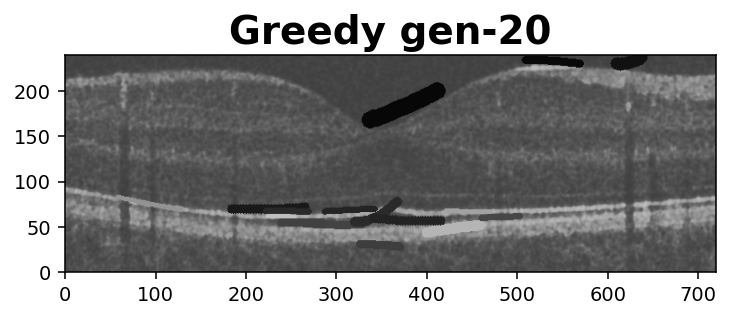

In [14]:
ga.run_generations(10)
ga.plot_clew()

Generation 21: SSIM = 0.301, Scores = 67 ± 25, [28, 122], Worms = 17  (took 0.89 sec)
Generation 22: SSIM = 0.303, Scores = 68 ± 24, [36, 122], Worms = 17  (took 0.24 sec)
Generation 23: SSIM = 0.301, Scores = 69 ± 22, [35, 116], Worms = 17  (took 0.25 sec)
Generation 24: SSIM = 0.301, Scores = 71 ± 24, [35, 116], Worms = 17  (took 0.24 sec)
Generation 25: SSIM = 0.303, Scores = 72 ± 24, [39, 124], Worms = 17  (took 0.23 sec)
Generation 26: SSIM = 0.304, Scores = 70 ± 24, [39, 124], Worms = 18  (took 0.90 sec)
Generation 27: SSIM = 0.304, Scores = 67 ± 26, [22, 124], Worms = 19  (took 0.90 sec)
Generation 28: SSIM = 0.304, Scores = 69 ± 26, [22, 123], Worms = 19  (took 0.25 sec)
Generation 29: SSIM = 0.303, Scores = 65 ± 28, [17, 123], Worms = 20  (took 0.84 sec)
Generation 30: SSIM = 0.303, Scores = 66 ± 26, [22, 114], Worms = 20  (took 0.26 sec)


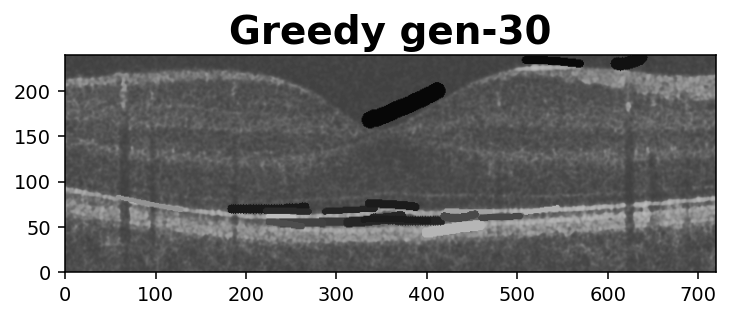

In [15]:
ga.run_generations(10)
ga.plot_clew()

Generation 31: SSIM = 0.304, Scores = 66 ± 26, [22, 114], Worms = 20  (took 0.29 sec)
Generation 32: SSIM = 0.305, Scores = 64 ± 26, [19, 114], Worms = 21  (took 0.94 sec)
Generation 33: SSIM = 0.306, Scores = 66 ± 27, [19, 123], Worms = 21  (took 0.26 sec)
Generation 34: SSIM = 0.306, Scores = 65 ± 27, [19, 123], Worms = 22  (took 0.92 sec)
Generation 35: SSIM = 0.305, Scores = 67 ± 26, [22, 123], Worms = 22  (took 0.27 sec)
Generation 36: SSIM = 0.306, Scores = 65 ± 26, [22, 123], Worms = 23  (took 0.88 sec)
Generation 37: SSIM = 0.306, Scores = 65 ± 25, [22, 123], Worms = 24  (took 0.90 sec)
Generation 38: SSIM = 0.306, Scores = 66 ± 24, [22, 123], Worms = 24  (took 0.29 sec)
Generation 39: SSIM = 0.307, Scores = 68 ± 24, [33, 121], Worms = 24  (took 0.29 sec)
Generation 40: SSIM = 0.305, Scores = 68 ± 24, [33, 121], Worms = 24  (took 0.37 sec)


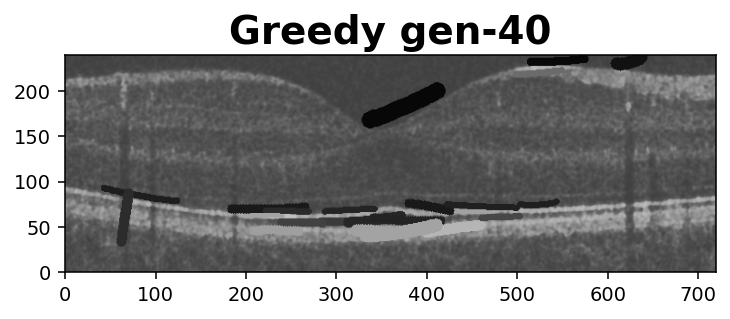

In [16]:
ga.run_generations(10)
ga.plot_clew()

Generation 41: SSIM = 0.306, Scores = 70 ± 22, [39, 121], Worms = 24  (took 0.29 sec)
Generation 42: SSIM = 0.307, Scores = 68 ± 23, [31, 121], Worms = 25  (took 0.93 sec)
Generation 43: SSIM = 0.308, Scores = 69 ± 23, [31, 121], Worms = 25  (took 0.31 sec)
Generation 44: SSIM = 0.308, Scores = 68 ± 23, [31, 121], Worms = 26  (took 0.95 sec)
Generation 45: SSIM = 0.308, Scores = 69 ± 22, [31, 121], Worms = 26  (took 0.31 sec)
Generation 46: SSIM = 0.309, Scores = 71 ± 24, [31, 123], Worms = 26  (took 0.31 sec)
Generation 47: SSIM = 0.309, Scores = 69 ± 24, [31, 123], Worms = 27  (took 0.96 sec)
Generation 48: SSIM = 0.308, Scores = 68 ± 25, [31, 123], Worms = 28  (took 0.94 sec)
Generation 49: SSIM = 0.310, Scores = 68 ± 24, [31, 123], Worms = 28  (took 0.34 sec)
Generation 50: SSIM = 0.310, Scores = 68 ± 23, [31, 123], Worms = 28  (took 0.34 sec)


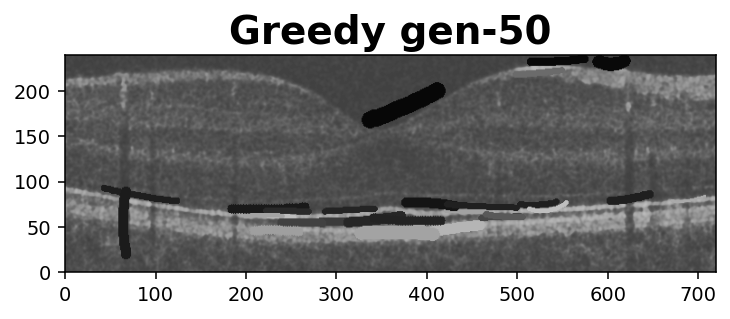

In [17]:
ga.run_generations(10)
ga.plot_clew()

Generation 51: SSIM = 0.309, Scores = 67 ± 24, [31, 123], Worms = 29  (took 0.97 sec)
Generation 52: SSIM = 0.312, Scores = 69 ± 23, [31, 123], Worms = 29  (took 0.40 sec)
Generation 53: SSIM = 0.313, Scores = 68 ± 23, [31, 123], Worms = 30  (took 0.95 sec)
Generation 54: SSIM = 0.314, Scores = 67 ± 24, [31, 123], Worms = 31  (took 1.00 sec)
Generation 55: SSIM = 0.315, Scores = 70 ± 26, [31, 133], Worms = 31  (took 0.36 sec)
Generation 56: SSIM = 0.314, Scores = 70 ± 26, [31, 133], Worms = 31  (took 0.37 sec)
Generation 57: SSIM = 0.313, Scores = 70 ± 25, [31, 133], Worms = 31  (took 0.35 sec)
Generation 58: SSIM = 0.312, Scores = 69 ± 25, [28, 133], Worms = 32  (took 1.01 sec)
Generation 59: SSIM = 0.312, Scores = 70 ± 25, [28, 133], Worms = 32  (took 0.37 sec)
Generation 60: SSIM = 0.312, Scores = 70 ± 25, [28, 133], Worms = 32  (took 0.37 sec)


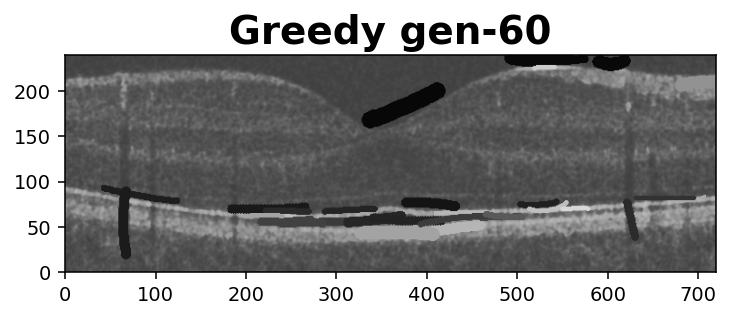

In [18]:
ga.run_generations(10)
ga.plot_clew()

Generation 61: SSIM = 0.312, Scores = 70 ± 25, [28, 133], Worms = 32  (took 0.37 sec)
Generation 62: SSIM = 0.312, Scores = 71 ± 26, [28, 133], Worms = 32  (took 0.37 sec)
Generation 63: SSIM = 0.310, Scores = 72 ± 25, [28, 133], Worms = 32  (took 0.38 sec)
Generation 64: SSIM = 0.311, Scores = 70 ± 26, [23, 133], Worms = 33  (took 1.02 sec)
Generation 65: SSIM = 0.311, Scores = 70 ± 26, [23, 133], Worms = 33  (took 0.43 sec)
Generation 66: SSIM = 0.312, Scores = 72 ± 25, [26, 133], Worms = 33  (took 0.36 sec)
Generation 67: SSIM = 0.311, Scores = 71 ± 25, [26, 133], Worms = 33  (took 0.38 sec)
Generation 68: SSIM = 0.313, Scores = 72 ± 24, [26, 133], Worms = 33  (took 0.38 sec)
Generation 69: SSIM = 0.313, Scores = 73 ± 24, [26, 133], Worms = 33  (took 0.39 sec)
Generation 70: SSIM = 0.314, Scores = 73 ± 23, [26, 133], Worms = 34  (took 1.04 sec)


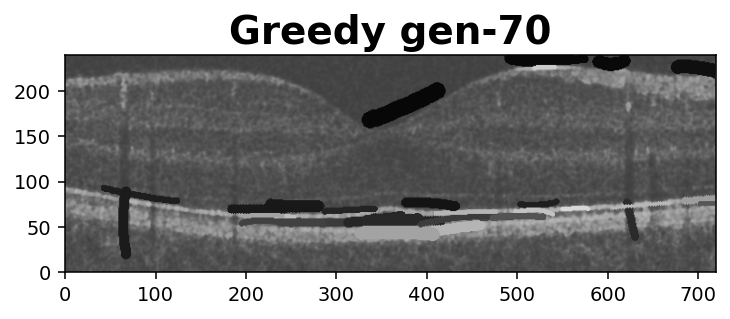

In [19]:
ga.run_generations(10)
ga.plot_clew()

Generation 71: SSIM = 0.313, Scores = 71 ± 24, [26, 133], Worms = 35  (took 1.06 sec)
Generation 72: SSIM = 0.314, Scores = 72 ± 24, [26, 133], Worms = 35  (took 0.38 sec)
Generation 73: SSIM = 0.314, Scores = 70 ± 25, [26, 133], Worms = 36  (took 1.05 sec)
Generation 74: SSIM = 0.314, Scores = 69 ± 25, [26, 133], Worms = 37  (took 1.04 sec)
Generation 75: SSIM = 0.313, Scores = 68 ± 25, [26, 133], Worms = 38  (took 1.08 sec)
Generation 76: SSIM = 0.314, Scores = 69 ± 24, [26, 133], Worms = 38  (took 0.44 sec)
Generation 77: SSIM = 0.316, Scores = 69 ± 24, [26, 133], Worms = 38  (took 0.43 sec)
Generation 78: SSIM = 0.315, Scores = 69 ± 24, [23, 133], Worms = 38  (took 0.49 sec)
Generation 79: SSIM = 0.315, Scores = 69 ± 24, [26, 133], Worms = 38  (took 0.47 sec)
Generation 80: SSIM = 0.315, Scores = 69 ± 23, [26, 133], Worms = 38  (took 0.43 sec)


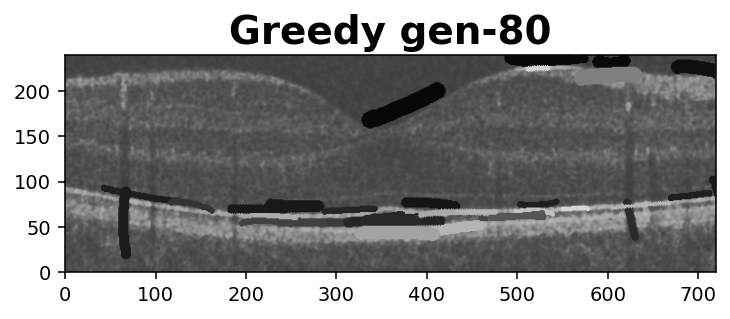

In [20]:
ga.run_generations(10)
ga.plot_clew()

Generation 81: SSIM = 0.317, Scores = 69 ± 23, [25, 133], Worms = 39  (took 1.07 sec)
Generation 82: SSIM = 0.317, Scores = 70 ± 23, [25, 133], Worms = 39  (took 0.42 sec)
Generation 83: SSIM = 0.317, Scores = 71 ± 24, [25, 133], Worms = 39  (took 0.44 sec)
Generation 84: SSIM = 0.318, Scores = 70 ± 25, [8, 133], Worms = 40  (took 1.10 sec)
Generation 85: SSIM = 0.318, Scores = 69 ± 25, [8, 133], Worms = 41  (took 1.13 sec)
Generation 86: SSIM = 0.318, Scores = 69 ± 25, [8, 133], Worms = 41  (took 0.46 sec)
Generation 87: SSIM = 0.317, Scores = 68 ± 25, [8, 133], Worms = 42  (took 1.15 sec)
Generation 88: SSIM = 0.318, Scores = 69 ± 25, [8, 133], Worms = 42  (took 0.48 sec)
Generation 89: SSIM = 0.319, Scores = 70 ± 25, [17, 133], Worms = 42  (took 0.48 sec)
Generation 90: SSIM = 0.318, Scores = 68 ± 25, [17, 133], Worms = 43  (took 1.15 sec)


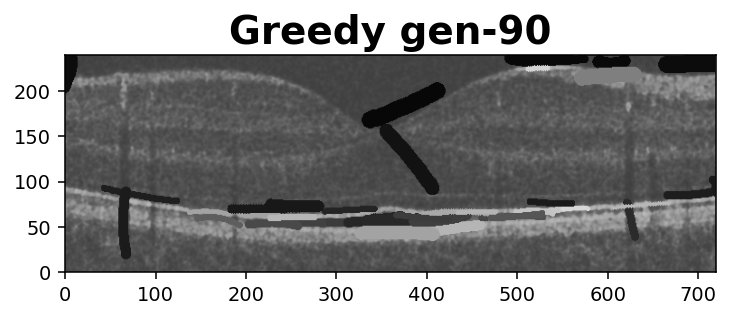

In [21]:
ga.run_generations(10)
ga.plot_clew()

Generation 91: SSIM = 0.319, Scores = 69 ± 24, [26, 133], Worms = 43  (took 0.48 sec)
Generation 92: SSIM = 0.318, Scores = 68 ± 24, [26, 133], Worms = 43  (took 0.49 sec)
Generation 93: SSIM = 0.319, Scores = 70 ± 24, [26, 133], Worms = 43  (took 0.49 sec)
Generation 94: SSIM = 0.319, Scores = 71 ± 24, [29, 130], Worms = 43  (took 0.49 sec)
Generation 95: SSIM = 0.318, Scores = 72 ± 24, [29, 130], Worms = 43  (took 0.50 sec)
Generation 96: SSIM = 0.318, Scores = 72 ± 24, [30, 130], Worms = 43  (took 0.50 sec)
Generation 97: SSIM = 0.318, Scores = 73 ± 23, [42, 130], Worms = 43  (took 0.50 sec)
Generation 98: SSIM = 0.317, Scores = 73 ± 24, [42, 130], Worms = 43  (took 0.47 sec)
Generation 99: SSIM = 0.317, Scores = 72 ± 25, [24, 130], Worms = 44  (took 1.16 sec)
Generation 100: SSIM = 0.317, Scores = 72 ± 25, [24, 130], Worms = 44  (took 0.54 sec)


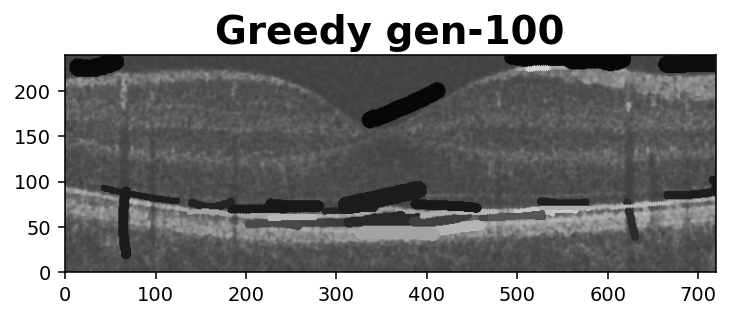

In [22]:
ga.run_generations(10)
ga.plot_clew()

Generation 101: SSIM = 0.317, Scores = 72 ± 25, [31, 130], Worms = 44  (took 0.51 sec)
Generation 102: SSIM = 0.316, Scores = 72 ± 25, [31, 130], Worms = 44  (took 0.51 sec)
Generation 103: SSIM = 0.317, Scores = 72 ± 25, [31, 130], Worms = 45  (took 1.26 sec)
Generation 104: SSIM = 0.317, Scores = 72 ± 25, [31, 130], Worms = 45  (took 0.51 sec)
Generation 105: SSIM = 0.317, Scores = 72 ± 25, [31, 130], Worms = 45  (took 0.52 sec)
Generation 106: SSIM = 0.316, Scores = 72 ± 25, [31, 130], Worms = 45  (took 0.52 sec)
Generation 107: SSIM = 0.317, Scores = 73 ± 25, [31, 130], Worms = 45  (took 0.53 sec)
Generation 108: SSIM = 0.317, Scores = 73 ± 25, [33, 130], Worms = 45  (took 0.53 sec)
Generation 109: SSIM = 0.318, Scores = 73 ± 25, [33, 130], Worms = 45  (took 0.52 sec)
Generation 110: SSIM = 0.319, Scores = 72 ± 25, [33, 130], Worms = 46  (took 1.22 sec)
Generation 111: SSIM = 0.318, Scores = 71 ± 26, [23, 130], Worms = 47  (took 1.22 sec)
Generation 112: SSIM = 0.321, Scores = 72 ±

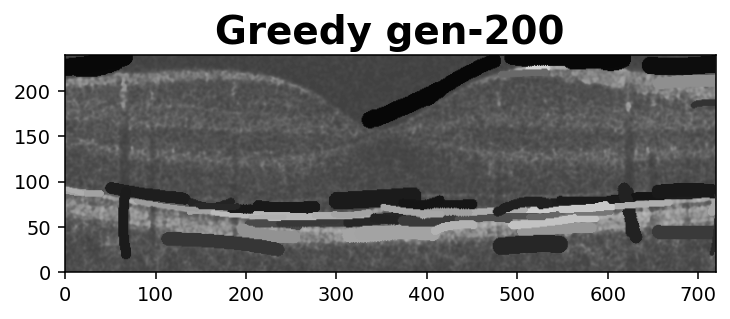

In [23]:
ga.run_generations(100)
ga.plot_clew()

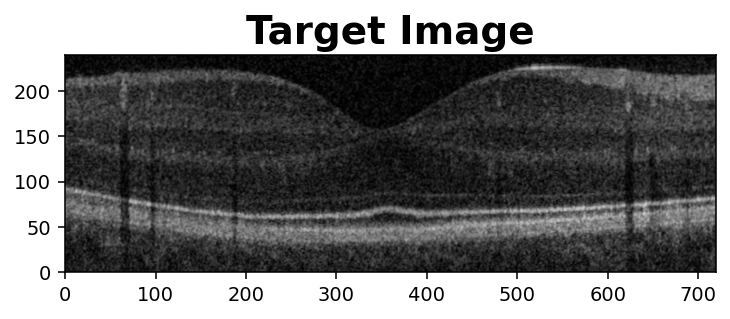

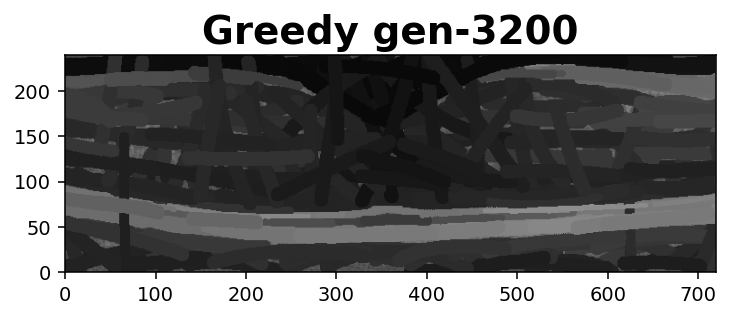

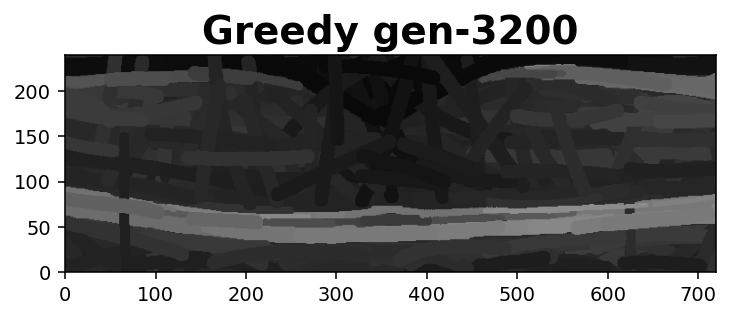

In [39]:
ga_image = ga.image
try:
    ga.image = image
    masks = locally_optimise_clew(ga.image, ga.clew)
    ga.clew_masks = [mask for mask, _ in masks]
    ga.plot_clew(show_target_image=True)
    ga.plot_clew(exclude_background=True)
finally:
    ga.image = ga_image

Generation 201: SSIM = 0.336, Scores = 37 ± 19, [7, 105], Worms = 76  (took 0.97 sec)
Generation 202: SSIM = 0.334, Scores = 40 ± 20, [11, 105], Worms = 76  (took 0.95 sec)
Generation 203: SSIM = 0.332, Scores = 45 ± 24, [11, 125], Worms = 76  (took 0.90 sec)
Generation 204: SSIM = 0.337, Scores = 45 ± 25, [11, 130], Worms = 76  (took 0.99 sec)
Generation 205: SSIM = 0.335, Scores = 48 ± 25, [11, 130], Worms = 76  (took 0.94 sec)
Generation 206: SSIM = 0.338, Scores = 50 ± 26, [11, 125], Worms = 76  (took 0.94 sec)
Generation 207: SSIM = 0.332, Scores = 53 ± 26, [10, 125], Worms = 76  (took 0.93 sec)
Generation 208: SSIM = 0.330, Scores = 53 ± 26, [10, 125], Worms = 76  (took 0.95 sec)
Generation 209: SSIM = 0.332, Scores = 56 ± 27, [8, 125], Worms = 76  (took 0.95 sec)
Generation 210: SSIM = 0.335, Scores = 59 ± 26, [11, 125], Worms = 76  (took 0.98 sec)
Generation 211: SSIM = 0.335, Scores = 59 ± 26, [11, 125], Worms = 76  (took 1.05 sec)
Generation 212: SSIM = 0.330, Scores = 61 ± 2

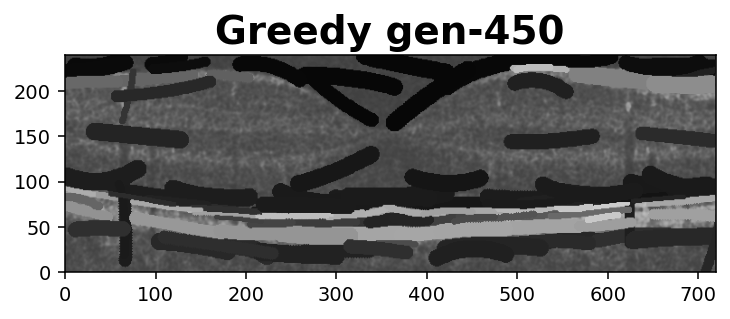

In [26]:
ga.run_generations(250)
ga.plot_clew()

Generation 451: SSIM = 0.382, Scores = 71 ± 24, [9, 129], Worms = 136  (took 2.18 sec)
Generation 452: SSIM = 0.382, Scores = 71 ± 24, [9, 129], Worms = 137  (took 3.24 sec)
Generation 453: SSIM = 0.378, Scores = 71 ± 24, [9, 129], Worms = 137  (took 2.19 sec)
Generation 454: SSIM = 0.379, Scores = 71 ± 24, [9, 129], Worms = 137  (took 2.19 sec)
Generation 455: SSIM = 0.379, Scores = 71 ± 24, [9, 129], Worms = 137  (took 2.26 sec)
Generation 456: SSIM = 0.379, Scores = 70 ± 25, [-36, 129], Worms = 138  (took 3.26 sec)
Generation 457: SSIM = 0.378, Scores = 70 ± 25, [-29, 130], Worms = 138  (took 2.22 sec)
Generation 458: SSIM = 0.378, Scores = 70 ± 25, [-13, 130], Worms = 138  (took 2.22 sec)
Generation 459: SSIM = 0.378, Scores = 71 ± 24, [9, 130], Worms = 137  (took 2.38 sec)
Generation 460: SSIM = 0.379, Scores = 71 ± 24, [9, 130], Worms = 138  (took 3.31 sec)
Generation 461: SSIM = 0.379, Scores = 71 ± 24, [9, 130], Worms = 138  (took 2.23 sec)
Generation 462: SSIM = 0.379, Scores 

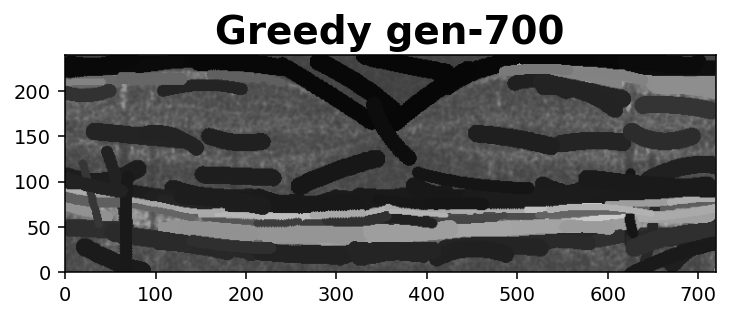

In [27]:
ga.run_generations(250)
ga.plot_clew()

Generation 701: SSIM = 0.391, Scores = 67 ± 22, [11, 138], Worms = 188  (took 3.63 sec)
Generation 702: SSIM = 0.392, Scores = 67 ± 22, [11, 138], Worms = 188  (took 3.54 sec)
Generation 703: SSIM = 0.392, Scores = 67 ± 22, [6, 138], Worms = 189  (took 4.85 sec)
Generation 704: SSIM = 0.392, Scores = 67 ± 22, [11, 138], Worms = 189  (took 3.54 sec)
Generation 705: SSIM = 0.393, Scores = 67 ± 22, [11, 138], Worms = 189  (took 3.55 sec)
Generation 706: SSIM = 0.390, Scores = 67 ± 22, [9, 138], Worms = 189  (took 3.53 sec)
Generation 707: SSIM = 0.391, Scores = 67 ± 22, [9, 138], Worms = 189  (took 3.56 sec)
Generation 708: SSIM = 0.391, Scores = 67 ± 22, [9, 138], Worms = 190  (took 4.90 sec)
Generation 709: SSIM = 0.391, Scores = 67 ± 22, [9, 138], Worms = 190  (took 3.62 sec)
Generation 710: SSIM = 0.391, Scores = 68 ± 21, [9, 138], Worms = 190  (took 3.59 sec)
Generation 711: SSIM = 0.391, Scores = 68 ± 21, [9, 138], Worms = 190  (took 3.62 sec)
Generation 712: SSIM = 0.392, Scores = 

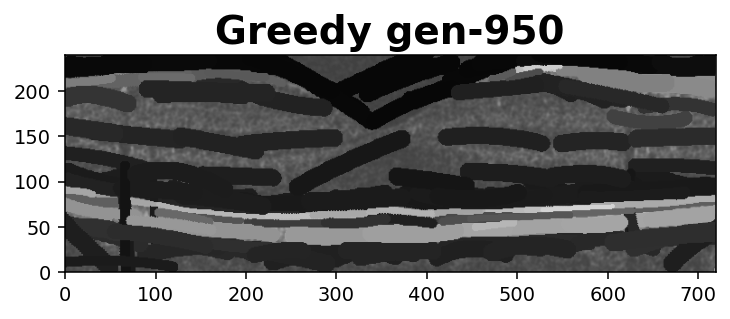

In [28]:
ga.run_generations(250)
ga.plot_clew()

Generation 951: SSIM = 0.408, Scores = 65 ± 20, [11, 114], Worms = 231  (took 6.54 sec)
Generation 952: SSIM = 0.408, Scores = 65 ± 20, [12, 114], Worms = 231  (took 5.13 sec)
Generation 953: SSIM = 0.407, Scores = 65 ± 20, [12, 114], Worms = 231  (took 4.93 sec)
Generation 954: SSIM = 0.409, Scores = 65 ± 20, [12, 114], Worms = 231  (took 4.91 sec)
Generation 955: SSIM = 0.409, Scores = 65 ± 20, [4, 114], Worms = 232  (took 6.45 sec)
Generation 956: SSIM = 0.410, Scores = 65 ± 20, [4, 114], Worms = 232  (took 4.92 sec)
Generation 957: SSIM = 0.410, Scores = 65 ± 20, [4, 114], Worms = 232  (took 4.91 sec)
Generation 958: SSIM = 0.410, Scores = 65 ± 20, [4, 114], Worms = 232  (took 4.92 sec)
Generation 959: SSIM = 0.411, Scores = 65 ± 20, [6, 114], Worms = 232  (took 4.89 sec)
Generation 960: SSIM = 0.411, Scores = 65 ± 20, [9, 114], Worms = 232  (took 4.91 sec)
Generation 961: SSIM = 0.411, Scores = 65 ± 20, [9, 112], Worms = 233  (took 6.41 sec)
Generation 962: SSIM = 0.410, Scores = 

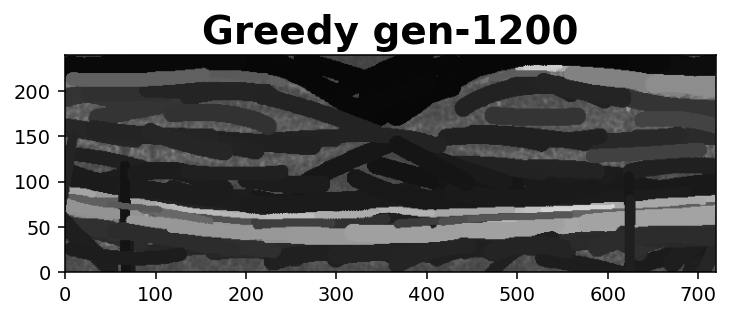

In [29]:
ga.run_generations(250)
ga.plot_clew()

Generation 1201: SSIM = 0.422, Scores = 61 ± 18, [13, 121], Worms = 269  (took 6.36 sec)
Generation 1202: SSIM = 0.419, Scores = 61 ± 18, [13, 121], Worms = 269  (took 6.30 sec)
Generation 1203: SSIM = 0.419, Scores = 61 ± 18, [13, 121], Worms = 269  (took 6.31 sec)
Generation 1204: SSIM = 0.422, Scores = 61 ± 18, [13, 121], Worms = 269  (took 6.29 sec)
Generation 1205: SSIM = 0.422, Scores = 61 ± 18, [13, 121], Worms = 269  (took 6.34 sec)
Generation 1206: SSIM = 0.422, Scores = 61 ± 18, [13, 121], Worms = 269  (took 6.33 sec)
Generation 1207: SSIM = 0.423, Scores = 61 ± 18, [13, 121], Worms = 270  (took 8.00 sec)
Generation 1208: SSIM = 0.422, Scores = 61 ± 18, [13, 121], Worms = 270  (took 6.31 sec)
Generation 1209: SSIM = 0.422, Scores = 61 ± 18, [13, 121], Worms = 270  (took 6.31 sec)
Generation 1210: SSIM = 0.422, Scores = 61 ± 18, [13, 121], Worms = 270  (took 6.30 sec)
Generation 1211: SSIM = 0.422, Scores = 61 ± 18, [13, 121], Worms = 270  (took 6.33 sec)
Generation 1212: SSIM

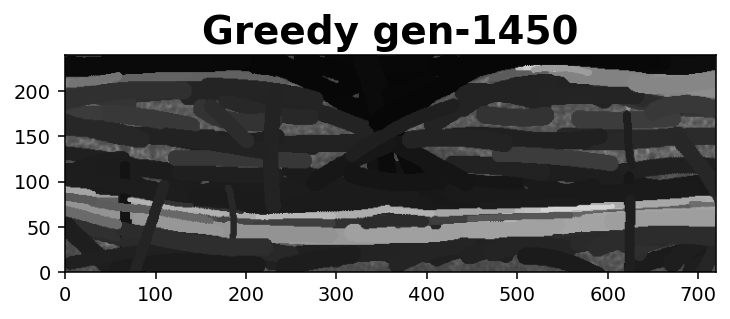

In [30]:
ga.run_generations(250)
ga.plot_clew()

Generation 1451: SSIM = 0.426, Scores = 57 ± 18, [2, 112], Worms = 307  (took 7.94 sec)
Generation 1452: SSIM = 0.426, Scores = 57 ± 18, [2, 112], Worms = 307  (took 7.94 sec)
Generation 1453: SSIM = 0.425, Scores = 57 ± 18, [2, 112], Worms = 307  (took 7.90 sec)
Generation 1454: SSIM = 0.426, Scores = 57 ± 18, [2, 112], Worms = 307  (took 7.98 sec)
Generation 1455: SSIM = 0.425, Scores = 57 ± 18, [2, 112], Worms = 307  (took 7.97 sec)
Generation 1456: SSIM = 0.424, Scores = 57 ± 18, [2, 112], Worms = 307  (took 7.93 sec)
Generation 1457: SSIM = 0.424, Scores = 57 ± 18, [1, 112], Worms = 308  (took 10.00 sec)
Generation 1458: SSIM = 0.424, Scores = 56 ± 18, [-2, 112], Worms = 309  (took 10.05 sec)
Generation 1459: SSIM = 0.425, Scores = 56 ± 18, [-2, 112], Worms = 309  (took 8.36 sec)
Generation 1460: SSIM = 0.425, Scores = 57 ± 18, [-2, 112], Worms = 309  (took 8.40 sec)
Generation 1461: SSIM = 0.425, Scores = 57 ± 18, [-2, 112], Worms = 309  (took 8.13 sec)
Generation 1462: SSIM = 0.

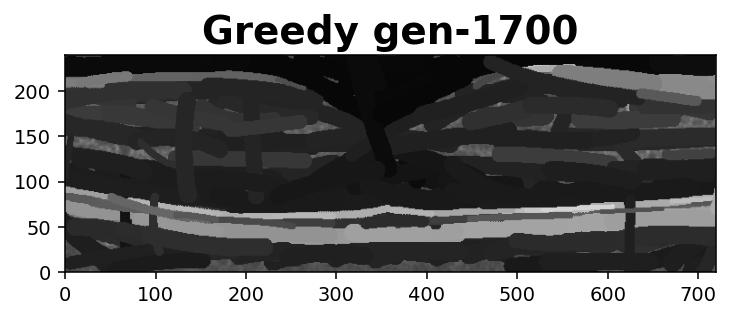

In [31]:
ga.run_generations(250)
ga.plot_clew()

Generation 1701: SSIM = 0.424, Scores = 53 ± 17, [1, 103], Worms = 338  (took 10.01 sec)
Generation 1702: SSIM = 0.424, Scores = 53 ± 17, [1, 103], Worms = 338  (took 9.28 sec)
Generation 1703: SSIM = 0.423, Scores = 53 ± 17, [1, 103], Worms = 338  (took 9.29 sec)
Generation 1704: SSIM = 0.424, Scores = 53 ± 17, [-2, 103], Worms = 338  (took 9.30 sec)
Generation 1705: SSIM = 0.424, Scores = 53 ± 17, [1, 103], Worms = 337  (took 9.82 sec)
Generation 1706: SSIM = 0.423, Scores = 53 ± 17, [-0, 111], Worms = 337  (took 9.23 sec)
Generation 1707: SSIM = 0.424, Scores = 53 ± 17, [1, 111], Worms = 337  (took 9.27 sec)
Generation 1708: SSIM = 0.424, Scores = 53 ± 17, [1, 111], Worms = 337  (took 9.32 sec)
Generation 1709: SSIM = 0.424, Scores = 53 ± 17, [-1, 111], Worms = 338  (took 11.41 sec)
Generation 1710: SSIM = 0.424, Scores = 53 ± 17, [1, 111], Worms = 337  (took 10.17 sec)
Generation 1711: SSIM = 0.424, Scores = 53 ± 17, [1, 111], Worms = 337  (took 9.31 sec)
Generation 1712: SSIM = 0.

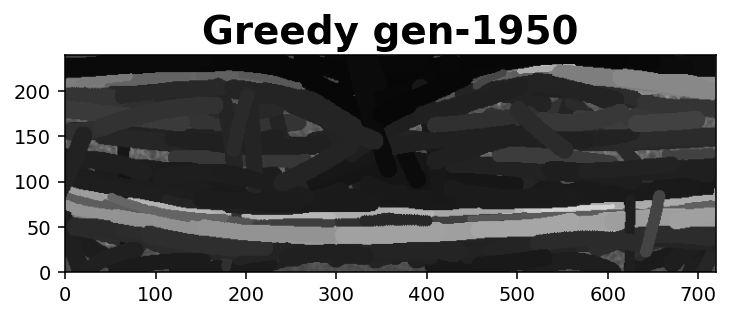

In [32]:
ga.run_generations(250)
ga.plot_clew()

Generation 1951: SSIM = 0.426, Scores = 51 ± 17, [-4, 108], Worms = 355  (took 10.41 sec)
Generation 1952: SSIM = 0.427, Scores = 51 ± 17, [-4, 108], Worms = 355  (took 10.38 sec)
Generation 1953: SSIM = 0.427, Scores = 51 ± 17, [-4, 108], Worms = 355  (took 10.41 sec)
Generation 1954: SSIM = 0.427, Scores = 51 ± 17, [-4, 108], Worms = 355  (took 10.35 sec)
Generation 1955: SSIM = 0.426, Scores = 51 ± 17, [-4, 108], Worms = 355  (took 10.39 sec)
Generation 1956: SSIM = 0.426, Scores = 51 ± 17, [-4, 108], Worms = 355  (took 10.35 sec)
Generation 1957: SSIM = 0.427, Scores = 51 ± 17, [-4, 108], Worms = 355  (took 10.30 sec)
Generation 1958: SSIM = 0.427, Scores = 51 ± 17, [6, 108], Worms = 354  (took 10.97 sec)
Generation 1959: SSIM = 0.427, Scores = 51 ± 17, [6, 108], Worms = 354  (took 10.36 sec)
Generation 1960: SSIM = 0.427, Scores = 51 ± 17, [6, 108], Worms = 354  (took 10.31 sec)
Generation 1961: SSIM = 0.426, Scores = 51 ± 17, [6, 108], Worms = 354  (took 10.29 sec)
Generation 196

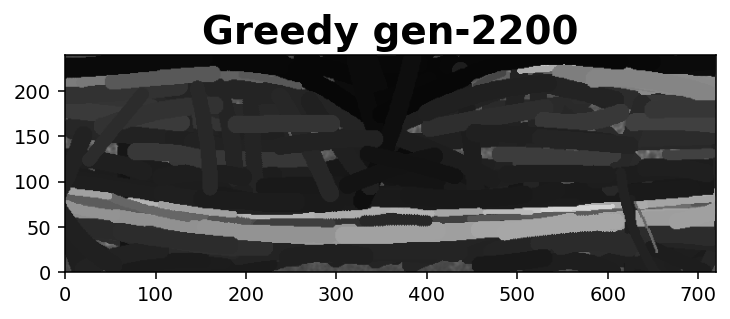

In [33]:
ga.run_generations(250)
ga.plot_clew()

Generation 2201: SSIM = 0.423, Scores = 49 ± 17, [-20, 107], Worms = 370  (took 11.32 sec)
Generation 2202: SSIM = 0.423, Scores = 49 ± 17, [-18, 107], Worms = 370  (took 11.29 sec)
Generation 2203: SSIM = 0.423, Scores = 49 ± 17, [-18, 107], Worms = 370  (took 11.30 sec)
Generation 2204: SSIM = 0.424, Scores = 49 ± 17, [-13, 107], Worms = 370  (took 11.34 sec)
Generation 2205: SSIM = 0.424, Scores = 50 ± 16, [2, 107], Worms = 369  (took 12.18 sec)
Generation 2206: SSIM = 0.424, Scores = 49 ± 16, [2, 107], Worms = 369  (took 11.18 sec)
Generation 2207: SSIM = 0.423, Scores = 50 ± 16, [7, 107], Worms = 369  (took 11.22 sec)
Generation 2208: SSIM = 0.424, Scores = 50 ± 16, [7, 107], Worms = 369  (took 11.22 sec)
Generation 2209: SSIM = 0.423, Scores = 50 ± 17, [-1, 107], Worms = 370  (took 13.61 sec)
Generation 2210: SSIM = 0.423, Scores = 49 ± 16, [-1, 100], Worms = 370  (took 11.24 sec)
Generation 2211: SSIM = 0.423, Scores = 49 ± 17, [-1, 100], Worms = 370  (took 11.22 sec)
Generation

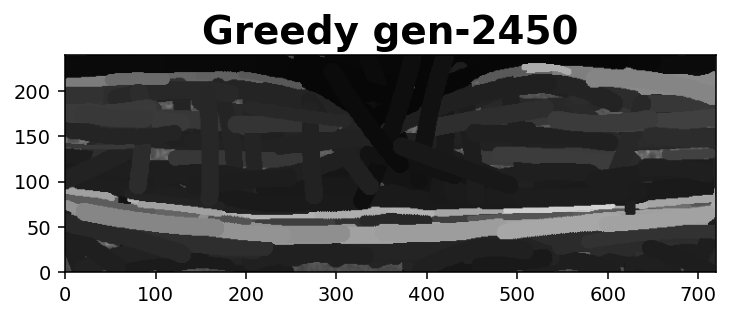

In [34]:
ga.run_generations(250)
ga.plot_clew()

Generation 2451: SSIM = 0.421, Scores = 48 ± 17, [-6, 100], Worms = 379  (took 11.80 sec)
Generation 2452: SSIM = 0.420, Scores = 48 ± 17, [7, 100], Worms = 378  (took 12.53 sec)
Generation 2453: SSIM = 0.420, Scores = 48 ± 17, [-4, 100], Worms = 379  (took 14.25 sec)
Generation 2454: SSIM = 0.419, Scores = 47 ± 17, [-4, 100], Worms = 379  (took 11.79 sec)
Generation 2455: SSIM = 0.419, Scores = 48 ± 17, [7, 100], Worms = 378  (took 12.63 sec)
Generation 2456: SSIM = 0.419, Scores = 48 ± 17, [7, 100], Worms = 378  (took 12.01 sec)
Generation 2457: SSIM = 0.419, Scores = 48 ± 16, [7, 100], Worms = 379  (took 14.35 sec)
Generation 2458: SSIM = 0.420, Scores = 47 ± 16, [7, 100], Worms = 379  (took 11.83 sec)
Generation 2459: SSIM = 0.419, Scores = 47 ± 16, [-11, 100], Worms = 380  (took 14.39 sec)
Generation 2460: SSIM = 0.420, Scores = 47 ± 16, [-11, 100], Worms = 380  (took 12.00 sec)
Generation 2461: SSIM = 0.419, Scores = 47 ± 16, [-11, 100], Worms = 380  (took 11.83 sec)
Generation 2

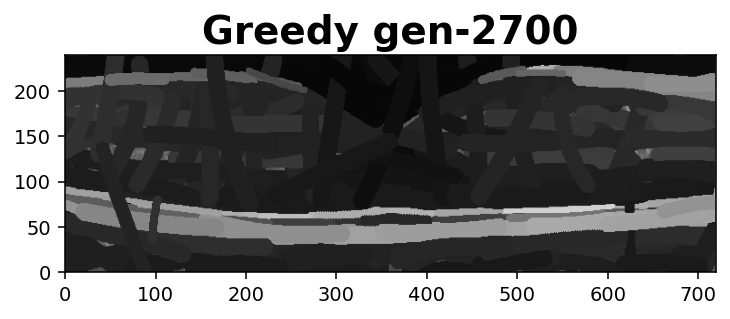

In [35]:
ga.run_generations(250)
ga.plot_clew()

Generation 2701: SSIM = 0.406, Scores = 45 ± 17, [-0, 96], Worms = 393  (took 15.50 sec)
Generation 2702: SSIM = 0.406, Scores = 45 ± 17, [-0, 96], Worms = 393  (took 12.65 sec)
Generation 2703: SSIM = 0.406, Scores = 45 ± 17, [-0, 96], Worms = 393  (took 12.75 sec)
Generation 2704: SSIM = 0.406, Scores = 46 ± 17, [-0, 96], Worms = 393  (took 12.88 sec)
Generation 2705: SSIM = 0.406, Scores = 46 ± 17, [2, 96], Worms = 392  (took 13.38 sec)
Generation 2706: SSIM = 0.406, Scores = 46 ± 17, [-15, 96], Worms = 393  (took 15.22 sec)
Generation 2707: SSIM = 0.406, Scores = 45 ± 17, [-15, 96], Worms = 393  (took 12.75 sec)
Generation 2708: SSIM = 0.406, Scores = 46 ± 17, [2, 96], Worms = 392  (took 13.48 sec)
Generation 2709: SSIM = 0.406, Scores = 45 ± 17, [-14, 96], Worms = 393  (took 15.48 sec)
Generation 2710: SSIM = 0.406, Scores = 45 ± 17, [-9, 96], Worms = 393  (took 12.81 sec)
Generation 2711: SSIM = 0.406, Scores = 46 ± 17, [2, 96], Worms = 392  (took 13.59 sec)
Generation 2712: SSIM

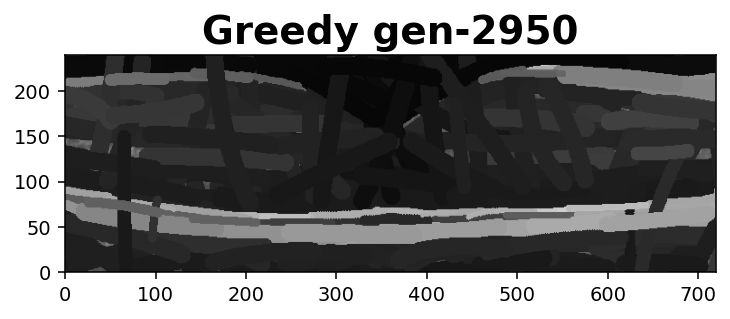

In [36]:
ga.run_generations(250)
ga.plot_clew()

Generation 2951: SSIM = 0.407, Scores = 44 ± 17, [-37, 96], Worms = 403  (took 16.05 sec)
Generation 2952: SSIM = 0.407, Scores = 44 ± 17, [-37, 96], Worms = 403  (took 13.38 sec)
Generation 2953: SSIM = 0.408, Scores = 44 ± 17, [-37, 96], Worms = 403  (took 13.34 sec)
Generation 2954: SSIM = 0.408, Scores = 44 ± 17, [-37, 96], Worms = 403  (took 13.35 sec)
Generation 2955: SSIM = 0.408, Scores = 45 ± 17, [1, 96], Worms = 402  (took 14.12 sec)
Generation 2956: SSIM = 0.408, Scores = 45 ± 17, [-5, 96], Worms = 403  (took 16.00 sec)
Generation 2957: SSIM = 0.408, Scores = 45 ± 17, [1, 96], Worms = 402  (took 14.09 sec)
Generation 2958: SSIM = 0.408, Scores = 45 ± 17, [1, 96], Worms = 402  (took 13.21 sec)
Generation 2959: SSIM = 0.408, Scores = 45 ± 17, [-13, 96], Worms = 403  (took 15.89 sec)
Generation 2960: SSIM = 0.408, Scores = 45 ± 17, [1, 96], Worms = 402  (took 14.03 sec)
Generation 2961: SSIM = 0.408, Scores = 45 ± 17, [-14, 96], Worms = 403  (took 15.94 sec)
Generation 2962: SS

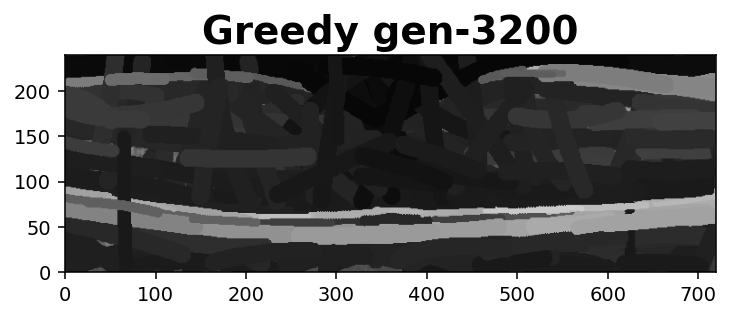

In [37]:
ga.run_generations(250)
ga.plot_clew()

In [68]:
import imageio
import pygifsicle
import cv2

filenames = []
for filename in os.listdir("progress"):
    if not filename.startswith("gen-") or not filename.endswith(".png"):
        continue

    num = int(filename[len("gen-"):-len(".png")])
    filenames.append((num, filename))

filenames.sort(key=lambda f: f[0])
filenames = [f for _, f in filenames]
filenames = filenames[:500] + filenames[500:1000:2] + filenames[1000::4]

images = []
for filename in filenames:
    progress_image = imageio.imread(os.path.join("progress", filename))
    progress_image = progress_image[117:-173, 104:-83]
    h, w, _ = progress_image.shape
    progress_image = cv2.resize(progress_image, dsize=(w // 2, h // 2))
    images.append(progress_image)

imageio.mimsave('progress.gif', images, duration=1.0/30)
pygifsicle.optimize("progress.gif")


gifsicle: warning: trivial adaptive palette (only 256 colors in source)
